FYS-STK project 2\
By David Svejda, Gianmarco Puleo and Henrik Breitenstein

All of the results are generated from scripts in this file

# Finding suitable parameter values

We start by optimising the learningrate, the number of epochs and the regularisation parameter lambda for stochastic gradient descent. First we optimise the learning rate and number of epoch with a small regularisation parameter by looking at how the accuracy and cross-entropy changes based on the parameters.

In [1]:
import Hyper as hp
import optimisers as op
import lrSchedules as lrs
import numpy as np
import Data
import ActivationFunctions as AF
import plot

## Momentum

Before optimizing the learning rate and number of epochs we need a suitable momentum when using Momentum GD. 
For all values of the momentum (here called $L$), the following cell outputs the best values of $\eta$ (lr) and number of epochs, based on the score on test.

In [2]:
#this is the set of momentums which we scan.
Llist = np.arange(1, 4, 0.5)
Lmd = 1e-4

#for each momentum, we do a grid search using the values 
#of learning rate and number of epochs defined in the following lists:
[lr_range, ep_range] = [np.logspace(-4, 0, 5), np.logspace(1, 2, 5)]

#define shape of net
shapes = (64, 10)

#import dataset 
train, test, val, train_tar, test_tar, val_tar = Data.load_data()
for L in Llist:#loop through various momenta
    name = None
    print(f'------------- Momentum = {L} -------------')
    #this function contains a nested loop over the n. epochs and the l.rate.
    hp.Run(L, lr_range, ep_range, 22, train, train_tar, test, test_tar, hp.Cross_Entropy, shapes, AF.SoftMax(), op.MomentumOptimiser, name, Lmd, 0, 0)

------------- Momentum = 1.0 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 17.78279410038923, Best Acc: 0.9220055710306406, Best CE: 0.15294275613648103
------------- Momentum = 1.5 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 10.0, Best Acc: 0.9442896935933147, Best CE: 0.14109393359624223
------------- Momentum = 2.0 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 56.23413251903491, Best Acc: 0.924791086350975, Best CE: 0.1872213599694304
------------- Momentum = 2.5 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 31.622776601683793, Best Acc: 0.924791086350975, Best CE: 0.18911837407921217
------------- Momentum = 3.0 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 10.0, Best Acc: 0.9080779944289693, Best CE: 0.2138984100702457
------------- Momentum = 3.5 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 100.0, Best Acc: 0.947075208913649, Best CE: 0.1602014780133041


Where we choose $\text{Momentum} = 1.5$ since this had the minimum cross entropy (here CE).
From now on we will leave this value of the momentum fixed every time we used momentum GD.

## Learning Rate Schedule

For optimizing parameters together with a learning rate schedule we first do a test on a smaller range of parameters to find a suitable value for the number of steps before the learning rate is halved. 

In [10]:
Llist = [0, 1.5] #Momentum
Lmd = 1e-4
[lr_range, ep_range, t1] = [np.logspace(-4, 0, 5), np.logspace(1, 2, 5), np.logspace(3, 2, 10)]
shapes = (64, 10)
train, test, val, train_tar, test_tar, val_tar = Data.load_data()
schedules = [lrs.hyperbolic_lr, lrs.linear_lr, lrs.exponential_lr]
opts = [op.Optimiser, op.MomentumOptimiser]
for n, opt in enumerate(opts):
    print(opt.__name__)
    for schedule in schedules:
        print(f'{schedule.__name__:-^20}')
        for t in t1:
            name = None
            print(f'------------- t1 = {t} -------------')
            hp.Run(Llist[n], lr_range, ep_range, 22, train, train_tar, test, test_tar, hp.Cross_Entropy, shapes, AF.SoftMax(), opt, name, Lmd, t, schedule)


Optimiser
---hyperbolic_lr----
------------- t1 = 1000.0 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 31.622776601683793, Best Acc: 0.9387186629526463, Best CE: 0.15966933370123856
------------- t1 = 774.263682681127 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 100.0, Best Acc: 0.935933147632312, Best CE: 0.16003433002200568
------------- t1 = 599.4842503189409 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 100.0, Best Acc: 0.924791086350975, Best CE: 0.16846270995504561
------------- t1 = 464.15888336127773 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 56.23413251903491, Best Acc: 0.924791086350975, Best CE: 0.18450111207549996
------------- t1 = 359.38136638046257 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 56.23413251903491, Best Acc: 0.9442896935933147, Best CE: 0.12441507540991674
------------- t1 = 278.2559402207126 -------------
.,,,,,.,,,,,.,,,,,.,,,,,.,,,,,

Lr: 0.1 , Epochs: 56.234132

Whith the best results being, in terms of accuracy:

Normal optimiser:

**hyperbolic schedule:** $\Theta = 215$ 

With momentum:

**hyperbolic schedule:** $\Theta = 464$


## Optimising the learning rate and the number of epochs
We are then ready to tune hyperparameters for five different optimisers: Momentum Optimiser, AdaGrad, Adam, RMSProp and Learning Rate Schedule optimiser. First we take a look at the results from each optimization step for the optimiser with momentum. The momentum was set to $1.5$ after testing a small range of momentums. With the regularisation parameter set to $\lambda = 10^{-4}$ we get the following heat map for accuracy and cross-entropy respectively. The heatmap is found after all of the tests.

In [23]:
[lr_range, ep_range] = [np.logspace(-4, 0, 10), np.logspace(2, 3, 10)]
Lmd = 1e-4

In [5]:
#Optimiser
hp.SendToLrEpoch(0, 215, lrs.hyperbolic_lr, op.Optimiser, lr_range, ep_range, Lmd, 'Optimiser')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.046415888336127774 , Epochs: 1000.0, Best Acc: 0.6072423398328691, Best CE: 2.9363187089031366


In [9]:
#MomentumOptimiser
hp.SendToLrEpoch(1.5, 464, lrs.hyperbolic_lr, op.MomentumOptimiser, lr_range, ep_range, Lmd, 'MomentumOptimiser')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.046415888336127774 , Epochs: 1000.0, Best Acc: 0.6935933147632312, Best CE: 2.1415721445518874


In [6]:
#AdaGradOptimiser
hp.SendToLrEpoch(0, 0, 0, op.AdaGradOptimiser, lr_range, ep_range, Lmd, 'AdaGradOptimiser')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.046415888336127774 , Epochs: 464.15888336127773, Best Acc: 0.7966573816155988, Best CE: 1.1940330588391206


In [24]:
#AdamOptimiser
hp.SendToLrEpoch(0, 0, 0, op.AdamOptimiser, lr_range, ep_range, Lmd, 'AdamOptimiser')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.005994842503189409 , Epochs: 1000.0, Best Acc: 0.9610027855153204, Best CE: 0.11536400475064448


In [25]:
#RMSPropOptimiser
hp.SendToLrEpoch(0, 0, 0, op.RMSPropOptimiser, lr_range, ep_range, Lmd, 'RMSPropOptimiser')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.002154434690031882 , Epochs: 599.4842503189409, Best Acc: 0.9665738161559888, Best CE: 0.08833068218576602


We plot them:

In [3]:
from plot import *
import os

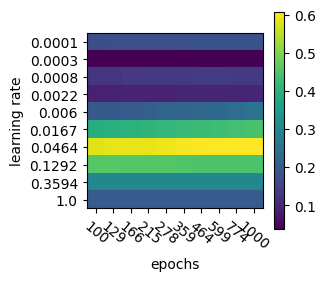

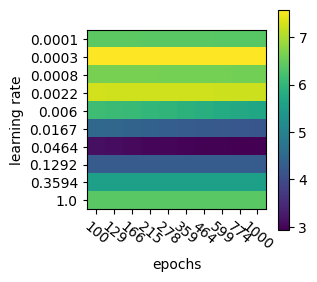

In [4]:
opt = 'Optimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
#observe that plot_lr_epochs takes a .npy file as argument, which contains the data that must be plotted
plot_lr_epochs(f'{base}/Acc_{opt}.npy', f"{opt}_Acc.png", f"{opt}_Acc", f"Data/Plots/{opt}_Acc.png")
plot_lr_epochs(f'{base}/Ent_{opt}.npy', f"{opt}_Ent.png", f"{opt}_Ent", f"Data/Plots/{opt}_Ent.png")

Where we choose: Lr $= 0.05$ and Epochs $= 600$.

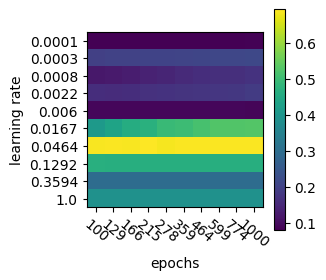

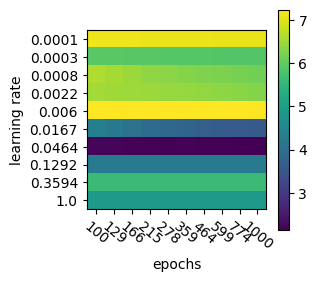

In [5]:
opt = 'MomentumOptimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
plot_lr_epochs(f'{base}/Acc_{opt}.npy', f"{opt}_Acc.png", f"{opt}_Acc", f"Data/Plots/{opt}_Acc.png")
plot_lr_epochs(f'{base}/Ent_{opt}.npy', f"{opt}_Ent.png", f"{opt}_Ent", f"Data/Plots/{opt}_Ent.png")

Where we choose: Lr $= 0.05$ and Epochs $= 100$.

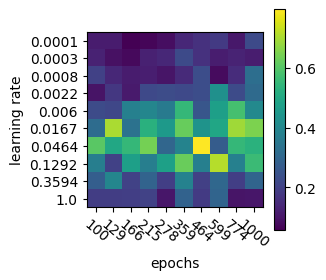

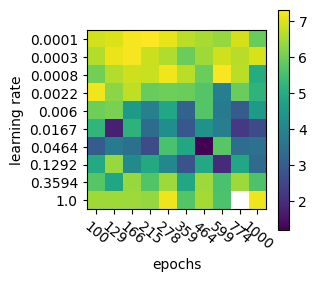

In [6]:
opt = 'AdaGradOptimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
plot_lr_epochs(f'{base}/Acc_{opt}.npy', f"{opt}_Acc.png", f"{opt}_Acc", f"Data/Plots/{opt}_Acc.png")
plot_lr_epochs(f'{base}/Ent_{opt}.npy', f"{opt}_Ent.png", f"{opt}_Ent", f"Data/Plots/{opt}_Ent.png")

Where we choose: Lr $= 0.05$ and Epochs $= 470$.

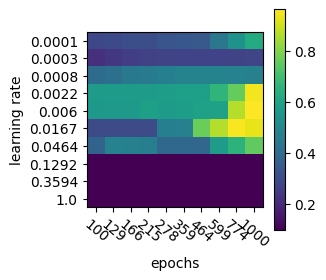

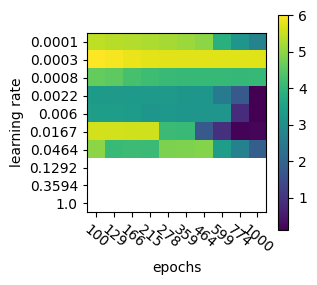

In [7]:
opt = 'AdamOptimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
plot_lr_epochs(f'{base}/Acc_{opt}.npy', f"{opt}_Acc.png", f"{opt}_Acc", f"Data/Plots/{opt}_Acc.png")
plot_lr_epochs(f'{base}/Ent_{opt}.npy', f"{opt}_Ent.png", f"{opt}_Ent", f"Data/Plots/{opt}_Ent.png")

Where we choose: Lr $= 0.006$ and Epochs $= 1000$.

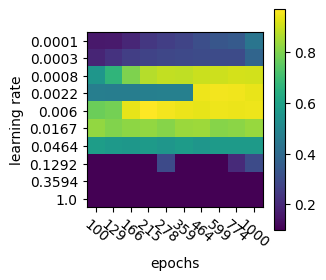

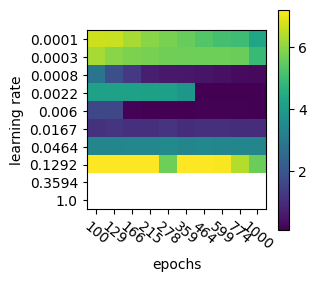

In [8]:
opt = 'RMSPropOptimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
plot_lr_epochs(f'{base}/Acc_{opt}.npy', f"{opt}_Acc.png", f"{opt}_Acc", f"Data/Plots/{opt}_Acc.png")
plot_lr_epochs(f'{base}/Ent_{opt}.npy', f"{opt}_Ent.png", f"{opt}_Ent", f"Data/Plots/{opt}_Ent.png")

Where we choose: Lr $= 0.002$ and Epochs $= 780$.

## Optimising Lambda

With these we optimize for the regularisation parameter $\lambda$

In [2]:
#Optimiser Momentum, Lr, Epochs, t1, opt, Lr_schedule
hp.SendToLambda(0, 0.05, 600, 215, op.Optimiser, lrs.hyperbolic_lr)

..................................................

Lmd: 0.00016768329368110067, Best Acc: 0.7075208913649025, Best CE: 0.7075208913649025


In [10]:
#MomentumOptimiser Momentum, Lr, Epochs, t1, opt, LrSchedule
hp.SendToLambda(1.5, 0.05, 100, 464, op.MomentumOptimiser, lrs.hyperbolic_lr)

..................................................

Lmd: 4.9417133613238384e-05, Best Acc: 0.6100278551532033, Best CE: 0.6100278551532033


In [2]:
#AdaGradOptimiser Momentum, Lr, Epochs, t1, opt, LrSchedule
hp.SendToLambda(0, 0.05, 470, 0, op.AdaGradOptimiser, 0)

..................................................

Lmd: 0.00013894954943731373, Best Acc: 0.9080779944289693, Best CE: 0.8969359331476323


In [28]:
#AdamOptimiser Momentum, Lr, Epochs, t1, opt, LrSchedule
hp.SendToLambda(0, 0.006, 1000, 0, op.AdamOptimiser, 0)

..................................................

Lmd: 0.0009102981779915217, Best Acc: 0.9693593314763231, Best CE: 0.958217270194986


In [29]:
#RMSPropOptimiser Momentum, Lr, Epochs, t1, opt, LrSchedule
hp.SendToLambda(0, 0.002, 780, 0, op.RMSPropOptimiser, 0)

..................................................

Lmd: 0.0009102981779915217, Best Acc: 0.9526462395543176, Best CE: 0.9442896935933147


We then plot the result

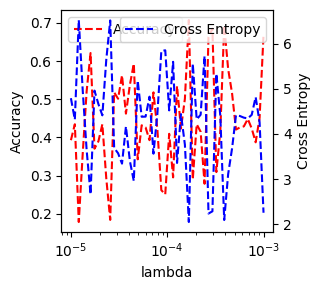

In [2]:
opt = 'Optimiser'
base = f'Data/NrHidden0/{opt}/Lambda'
plot.plot_lamda(f'{base}/Acc_Ent.npy', f'{opt}', f'Data/Plots/{opt}Lambda.png')

We then choose $\lambda = 10^{-4}$ for the normal optimiser.

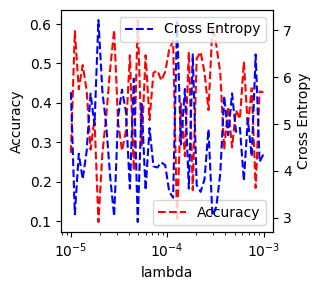

In [3]:
opt = 'MomentumOptimiser'
base = f'Data/NrHidden0/{opt}/Lambda'
plot.plot_lamda(f'{base}/Acc_Ent.npy', f'{opt}', f'Data/Plots/{opt}Lambda.png')

We then choose $\lambda = 5*10^{-5}$ for optimiser with momentum.

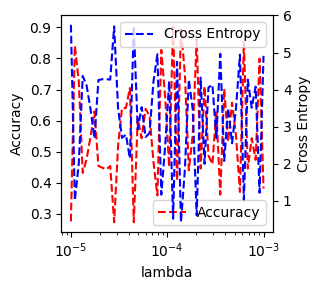

In [4]:
opt = 'AdaGradOptimiser'
base = f'Data/NrHidden0/{opt}/Lambda'
plot.plot_lamda(f'{base}/Acc_Ent.npy', f'{opt}', f'Data/Plots/{opt}Lambda.png')

We then choose $\lambda = 2*10^{-4}$ for AdaGradOptimiser.

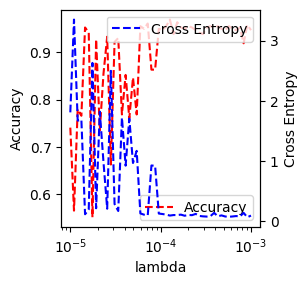

In [5]:
opt = 'AdamOptimiser'
base = f'Data/NrHidden0/{opt}/Lambda'
plot.plot_lamda(f'{base}/Acc_Ent.npy', f'{opt}', f'Data/Plots/{opt}Lambda.png')

We then choose $\lambda = 3*10^{-4}$ for AdamOptimiser.

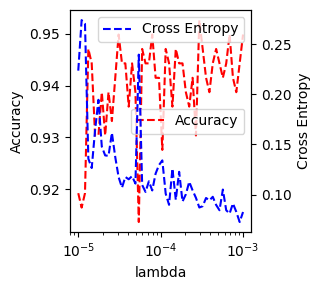

In [6]:
opt = 'RMSPropOptimiser'
base = f'Data/NrHidden0/{opt}/Lambda'
plot.plot_lamda(f'{base}/Acc_Ent.npy', f'{opt}', f'Data/Plots/{opt}Lambda.png')

We then choose $\lambda = 2*10^{-4}$ for RMSPropOptimiser.

With these we can now do another scan of the learning rate and number of epochs.

In [7]:
[lr_range, ep_range] = [np.logspace(-2, -1, 10), np.logspace(2, 3, 10)]
#Optimiser
Lmd = 1e-4
hp.SendToLrEpoch(0, 215, lrs.hyperbolic_lr, op.Optimiser, lr_range, ep_range, Lmd, 'OptimiserNr2')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.027825594022071243 , Epochs: 1000.0, Best Acc: 0.5626740947075209, Best CE: 3.3684604930013133


In [8]:
[lr_range, ep_range] = [np.logspace(-2, -1, 10), np.logspace(1, 2.5, 10)]
Lmd = 5e-5
#MomentumOptimiser
hp.SendToLrEpoch(0, 464, lrs.hyperbolic_lr, op.MomentumOptimiser, lr_range, ep_range, Lmd, 'MomentumOptimiserNr2')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.0774263682681127 , Epochs: 316.22776601683796, Best Acc: 0.7576601671309192, Best CE: 1.791589654075636


In [14]:
[lr_range, ep_range] = [np.logspace(-2, -1, 10), np.logspace(2.3, 2.85, 10)] #10^2.3 approx 200
Lmd = 2e-4
#AdaGradOptimiser
hp.SendToLrEpoch(0, 0, 0, op.AdaGradOptimiser, lr_range, ep_range, Lmd, 'AdaGradOptimiserNr2')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.05994842503189409 , Epochs: 229.67361763386364, Best Acc: 0.8356545961002786, Best CE: 1.1235440837667587


In [32]:
[lr_range, ep_range] = [np.logspace(-4, -3, 10), np.logspace(2.6, 3.2, 10)]
Lmd = 3e-4
#AdamOptimiser
hp.SendToLrEpoch(0, 0, 0, op.AdamOptimiser, lr_range, ep_range, Lmd, 'AdamOptimiserNr2')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.001 , Epochs: 1359.356390878527, Best Acc: 0.9526462395543176, Best CE: 0.0731723237673247


In [33]:
[lr_range, ep_range] = [np.logspace(-3, -2, 10), np.logspace(2.8, 3.2, 10)] #10^2.8 = 630
Lmd = 2e-4
#RMSPropOptimiser
hp.SendToLrEpoch(0, 0, 0, op.RMSPropOptimiser, lr_range, ep_range, Lmd, 'RMSPropOptimiserNr2')

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.001291549665014884 , Epochs: 1052.5002852777327, Best Acc: 0.9526462395543176, Best CE: 0.08325260670166201


We then plot them

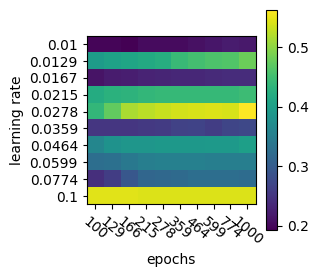

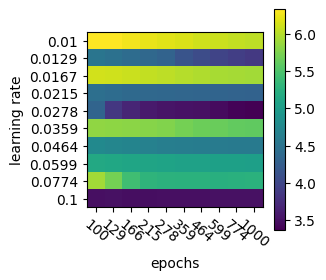

In [9]:
opt = 'Optimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
plot.plot_lr_epochs(f'{base}/Acc_{opt}Nr2.npy', f'{opt}', f'{opt}_Acc', f'Data/Plots/2nd{opt}Acc.png')
plot.plot_lr_epochs(f'{base}/Ent_{opt}Nr2.npy', f'{opt}', f'{opt}_Ent', f'Data/Plots/2nd{opt}Ent.png')

We then choose $\text{Lr} = 0.025$ with $\text{Epochs} = 1000$

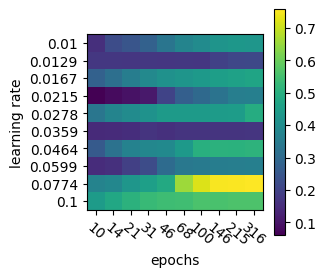

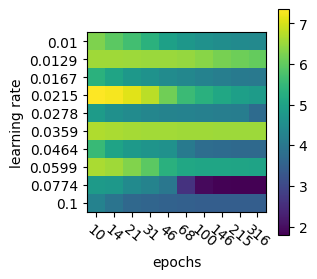

In [10]:
opt = 'MomentumOptimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
plot.plot_lr_epochs(f'{base}/Acc_{opt}Nr2.npy', f'{opt}', f'{opt}_Acc', f'Data/Plots/2nd{opt}Acc.png')
plot.plot_lr_epochs(f'{base}/Ent_{opt}Nr2.npy', f'{opt}', f'{opt}_Ent', f'Data/Plots/2nd{opt}Ent.png')

We then choose $\text{Lr} = 0.08$ with $\text{Epochs} = 1000$.

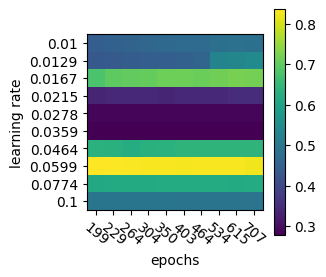

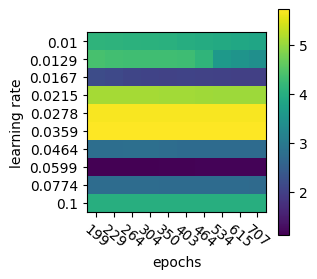

In [11]:
opt = 'AdaGradOptimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
plot.plot_lr_epochs(f'{base}/Acc_{opt}Nr2.npy', f'{opt}', f'{opt}_Acc', f'Data/Plots/2nd{opt}Acc.png')
plot.plot_lr_epochs(f'{base}/Ent_{opt}Nr2.npy', f'{opt}', f'{opt}_Ent', f'Data/Plots/2nd{opt}Ent.png')

From this we choose $\text{Lr}=0.06$ and $\text{Epochs}=200$.

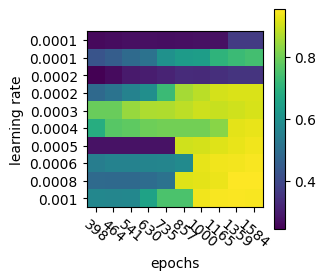

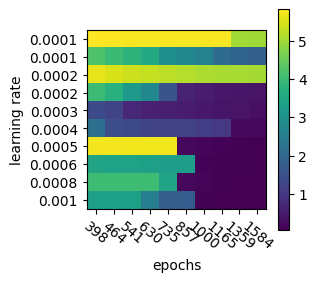

In [12]:
opt = 'AdamOptimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
plot.plot_lr_epochs(f'{base}/Acc_{opt}Nr2.npy', f'{opt}', f'{opt}_Acc', f'Data/Plots/2nd{opt}Acc.png')
plot.plot_lr_epochs(f'{base}/Ent_{opt}Nr2.npy', f'{opt}', f'{opt}_Ent', f'Data/Plots/2nd{opt}Ent.png')

We choose then$\text{Lr} = 0.0008$ and $\text{Epochs}=1600$

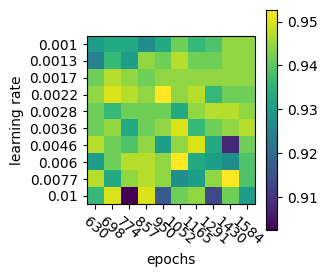

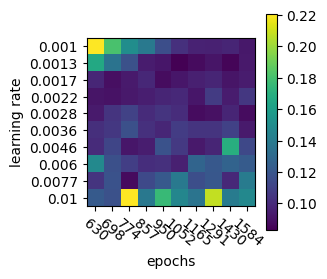

In [13]:
opt = 'RMSPropOptimiser'
base = f'Data/NrHidden0/{opt}/LrEpoch'
plot.plot_lr_epochs(f'{base}/Acc_{opt}Nr2.npy', f'{opt}', f'{opt}_Acc', f'Data/Plots/2nd{opt}Acc.png')
plot.plot_lr_epochs(f'{base}/Ent_{opt}Nr2.npy', f'{opt}', f'{opt}_Ent', f'Data/Plots/2nd{opt}Ent.png')

We choose then $\text{Lr} = 0.002$ and $\text{Epochs} = 950$

To see which optimiser performs the best we feed it the validation data

Optimiser: Optimiser, Mean Accuracy: 0.3303621169916434, Std: 0.115611973618949
Optimiser: Optimiser, Mean Cross Entropy: 5.1095509814423945, Std: 0.9872512913610678
Optimiser: Momentum, Mean Accuracy: 0.44512534818941507, Std: 0.1187609936701573
Optimiser: Momentum, Mean Cross Entropy: 4.257260724007573, Std: 1.0456816445305233
Optimiser: AdaGrad, Mean Accuracy: 0.4233983286908078, Std: 0.1379097354586367
Optimiser: AdaGrad, Mean Cross Entropy: 4.486686449078688, Std: 1.189659507986653
Optimiser: Adam, Mean Accuracy: 0.8846796657381615, Std: 0.0028406793947591993
Optimiser: Adam, Mean Cross Entropy: 0.2945486268686806, Std: 0.01256580752194714
Optimiser: RMSProp, Mean Accuracy: 0.8924791086350975, Std: 0.0033426183844011154
Optimiser: RMSProp, Mean Cross Entropy: 0.3279096664932045, Std: 0.008818062557058737


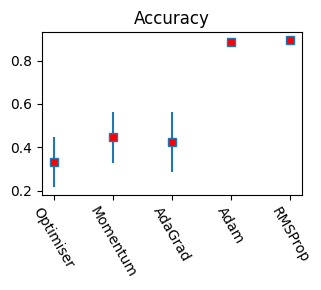

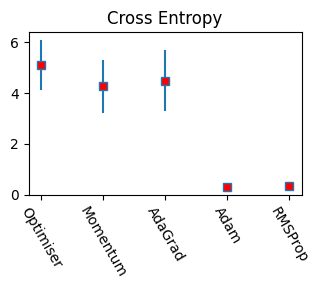

In [2]:
import validate as vld

opt1 = op.LrScheduleOptimiser(lrs.hyperbolic_lr(2.5e-2, 215), op.Optimiser(2.5e-2))
opt2 = op.LrScheduleOptimiser(lrs.hyperbolic_lr(8e-2, 464), op.MomentumOptimiser(8e-2, momentum=1.5))
optimisers = [opt1, opt2, op.AdaGradOptimiser(6e-2), op.AdamOptimiser(8e-4), op.RMSPropOptimiser(2e-3)]
opt_names = ['Optimiser', 'Momentum', 'AdaGrad', 'Adam', 'RMSProp']
n_epochs = [1000, 1000, 200, 1600, 950]
Lmds = [1e-4, 5e-5, 2e-4, 3e-4, 2e-4]
vld.validate(n_epochs, optimisers, opt_names, Lmds, [], (64, 10), '1st_validation')

We try to visualize the output layers' weigths as a heatmap as well for one of our best performing optimiser: Adam optimiser.

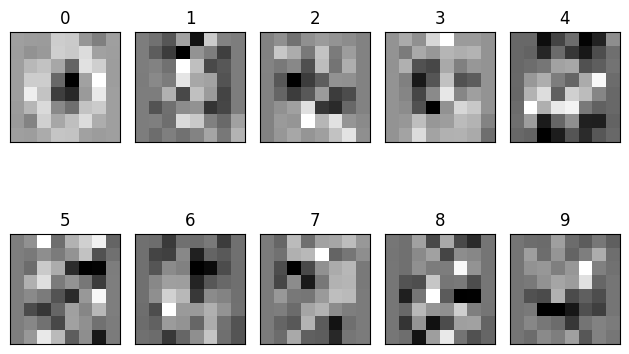

In [22]:
import plotweights as pw
import imp

imp.reload(pw)
pw.weights_heat(8e-4, 1600, op.AdamOptimiser, 3e-4, [AF.SoftMax()], (64, 10), '1stAdamVisual', (2, 5))

# One hidden layer

We have studied the performance of the Logistic regression, but now we want to see if we can do better with a \"real\" neural net. We add a hidden layer with 25 nodes, because 25 is about half way between 10 and 64, geometrically.

In [1]:
import Hyper as hp
import optimisers as op
import lrSchedules as lrs
import numpy as np
import Data
import ActivationFunctions as AF
import plot

In [2]:
[lr_range, ep_range] = [np.logspace(-2, 2, 10), np.logspace(2, 3, 10)]
Lmd = 1e-4
shape = (64, 25, 10)
#Optimiser
hp.NetworkToLrEpoch(0, 215, lrs.hyperbolic_lr, op.Optimiser, lr_range, ep_range,
                    Lmd,'Optimiser_sigmoid', AF.Sigmoid(), shape)

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 35.93813663804626 , Epochs: 1000.0, Best Acc: 0.9275766016713092, Best CE: 0.11401877741231868


In [2]:
[lr_range, ep_range] = [np.logspace(-2, 2, 10), np.logspace(2, 3, 10)]
Lmd = 1e-4
shape = (64, 25, 10)
#MomentumOptimiser
hp.NetworkToLrEpoch(1.5, 464, lrs.hyperbolic_lr, op.MomentumOptimiser, lr_range, ep_range,
                 Lmd, 'MomentumOptimiser_sigmoid', AF.Sigmoid(), shape)

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 1.6681005372000592 , Epochs: 100.0, Best Acc: 0.9387186629526463, Best CE: 0.135633201909392


In [3]:
[lr_range, ep_range] = [np.logspace(-2, 2, 10), np.logspace(2, 3, 10)]
Lmd = 1e-4
shape = (64, 25, 10)
#AdaGradOptimiser
hp.NetworkToLrEpoch(0, 0, 0, op.AdaGradOptimiser, lr_range, ep_range,
                 Lmd, 'AdaGradOptimiser_sigmoid', AF.Sigmoid(), shape)

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.21544346900318834 , Epochs: 1000.0, Best Acc: 0.9749303621169917, Best CE: 0.04623207952632097


In [11]:
[lr_range, ep_range] = [np.logspace(-4, 0, 10), np.logspace(2, 3, 10)]
Lmd = 1e-4
shape = (64, 25, 10)
#AdamOptimiser
hp.NetworkToLrEpoch(0, 0, 0, op.AdamOptimiser, lr_range, ep_range,
                 Lmd, 'AdamOptimiser_sigmoid', AF.Sigmoid(), shape)

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.016681005372000592 , Epochs: 774.263682681127, Best Acc: 0.9665738161559888, Best CE: 0.0530268939592448


In [12]:
[lr_range, ep_range] = [np.logspace(-4, 0, 10), np.logspace(2, 3, 10)]
Lmd = 1e-4
shape = (64, 25, 10)
#RMSPropOptimiser
hp.NetworkToLrEpoch(0, 0, 0, op.RMSPropOptimiser, lr_range, ep_range,
                    Lmd, 'RMSPropOptimiser_sigmoid', AF.Sigmoid(), shape)

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.005994842503189409 , Epochs: 359.38136638046257, Best Acc: 0.9777158774373259, Best CE: 0.043212496973005436


We plot them:

In [15]:
from plot import *
import os

target = f"Data/Plots/NrHidden1/"
os.makedirs(target, exist_ok=True)

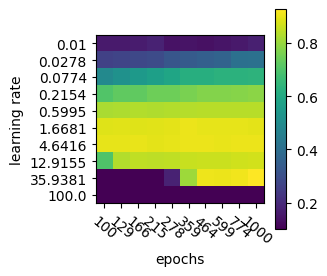

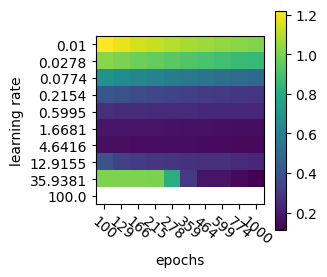

In [21]:
opt = 'Optimiser'
base = f'Data/NrHidden1/{opt}/LrEpoch'
for item in os.listdir(base):
    if not item.endswith("_2.npy"):
        plot_lr_epochs(f'{base}/{item}', f"{opt}{item[:3]}.png", f"{opt}{item[:3]}", f"{target}{opt}{item[:3]}.png")

We will further investigate the effect of lambda around $Lr = 4$ and $epochs = 500$

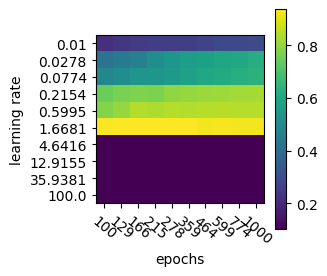

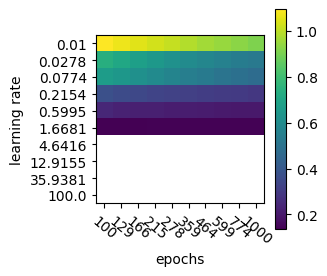

In [20]:
opt = 'MomentumOptimiser'
base = f'Data/NrHidden1/{opt}/LrEpoch'
for item in os.listdir(base):
    if not item.endswith("_2.npy"):
        plot_lr_epochs(f'{base}/{item}', f"{opt}{item[:3]}.png", f"{opt}{item[:3]}", f"{target}{opt}{item[:3]}.png")

We will further investigate the effect of lambda around $Lr = 1$ and $epochs = 300$

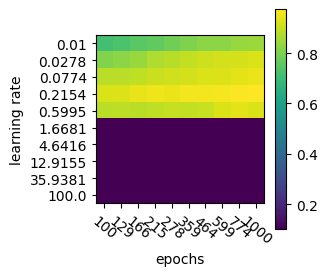

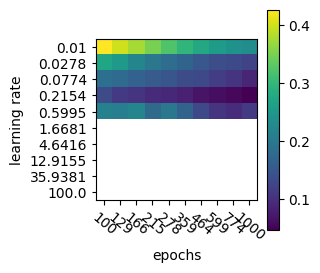

In [19]:
opt = 'AdaGradOptimiser'
base = f'Data/NrHidden1/{opt}/LrEpoch'
for item in os.listdir(base):
    if not item.endswith("_2.npy"):
        plot_lr_epochs(f'{base}/{item}', f"{opt}{item[:3]}.png", f"{opt}{item[:3]}", f"{target}{opt}{item[:3]}.png")

We will further investigate the effect of lambda around $Lr = 0.2$ and $epochs = 1000$

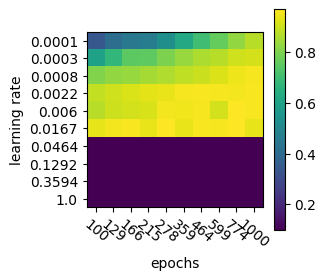

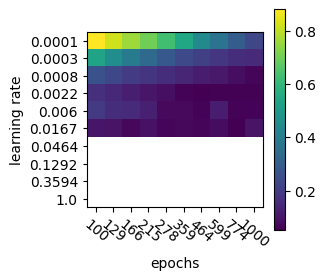

In [18]:
opt = 'AdamOptimiser'
base = f'Data/NrHidden1/{opt}/LrEpoch'
for item in os.listdir(base):
    if not item.endswith("_2.npy"):
        plot_lr_epochs(f'{base}/{item}', f"{opt}{item[:3]}.png", f"{opt}{item[:3]}", f"{target}{opt}{item[:3]}.png")

We will further investigate the effect of lambda around $Lr = 0.01$ and $epochs = 600$

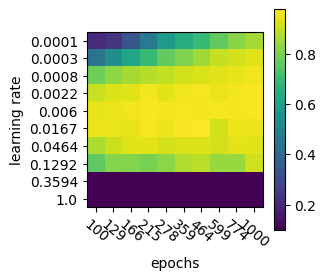

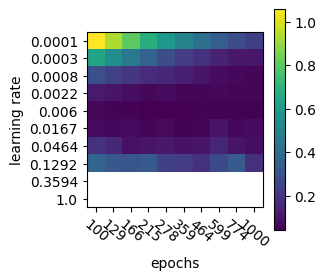

In [17]:
opt = 'RMSPropOptimiser'
base = f'Data/NrHidden1/{opt}/LrEpoch'
for item in os.listdir(base):
    if not item.endswith("_2.npy"):
        plot_lr_epochs(f'{base}/{item}', f"{opt}{item[:3]}.png", f"{opt}{item[:3]}", f"{target}{opt}{item[:3]}.png")

We will further investigate the effect of lambda around $Lr = 0.01$ and $epochs = 500$

## Optimising Lambda
We will now test some values of lambda with the values of Lr and the number of epochs as found by the previous set of calculations

In [1]:
import Hyper as hp
import optimisers as op
import lrSchedules as lrs
import ActivationFunctions as AF

In [2]:
shape = (64, 25, 10)
# Momentum, Learning rate, Epochs, Learning rate schedule parameter, optimiser, Learning rate schedule, activation function, shape
hp.NetworkToLambda(0, 4, 500, 215, op.Optimiser, lrs.hyperbolic_lr, AF.Sigmoid(), shape)

..................................................

Lmd: 0.0006250551925273969, Best Acc: 0.9721448467966574, Best CE: 0.9665738161559888


In [3]:
shape = (64, 25, 10)
# Momentum, Learning rate, Epochs, Learning rate schedule parameter, optimiser, Learning rate schedule, activation function, shape
hp.NetworkToLambda(1.5, 1, 300, 450, op.MomentumOptimiser, lrs.hyperbolic_lr, AF.Sigmoid(), shape)

..................................................

Lmd: 0.0009102981779915217, Best Acc: 0.947075208913649, Best CE: 0.9442896935933147


In [4]:
shape = (64, 25, 10)
# Momentum, Learning rate, Epochs, Learning rate schedule parameter, optimiser, Learning rate schedule, activation function, shape
hp.NetworkToLambda(0, 0.2, 1000, 0, op.AdaGradOptimiser, 0, AF.Sigmoid(), shape)

..................................................

Lmd: 0.00020235896477251554, Best Acc: 0.9749303621169917, Best CE: 0.9610027855153204


In [5]:
shape = (64, 25, 10)
# Momentum, Learning rate, Epochs, Learning rate schedule parameter, optimiser, Learning rate schedule, activation function, shape
hp.NetworkToLambda(0, 0.01, 600, 0, op.AdamOptimiser, 0, AF.Sigmoid(), shape)

..................................................

Lmd: 0.00013894954943731373, Best Acc: 0.9749303621169917, Best CE: 0.958217270194986


In [7]:
shape = (64, 25, 10)
# Momentum, Learning rate, Epochs, Learning rate schedule parameter, optimiser, Learning rate schedule, activation function, shape
hp.NetworkToLambda(0, 0.01, 500, 0, op.RMSPropOptimiser, 0, AF.Sigmoid(), shape)

...................................

And then we plot the data

In [8]:
from plot import *
import os

target = f"Data/Plots/NrHidden1/"
os.makedirs(target, exist_ok=True)

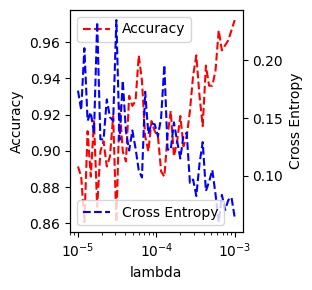

In [9]:
opt = 'Optimiser'
base = f'Data/NrHidden1/{opt}/Lambda'
plot_lamda(f'{base}/Acc_Ent.npy', f'{opt}', f'{target}{opt}Lambda.png')

Based on this we choose $\lambda = 1*10^{-3}$

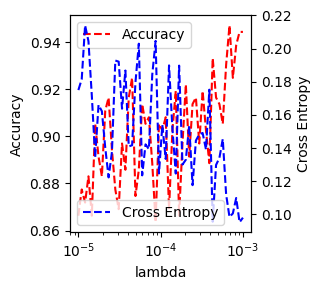

In [10]:
opt = 'MomentumOptimiser'
base = f'Data/NrHidden1/{opt}/Lambda'
plot_lamda(f'{base}/Acc_Ent.npy', f'{opt}', f'{target}{opt}Lambda.png')

Based on this we choose $\lambda = 1*10^{-3}$

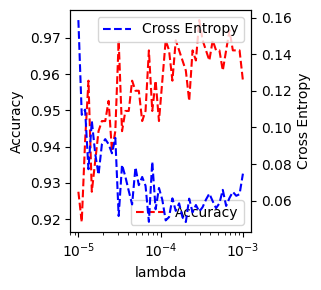

In [11]:
opt = 'AdaGradOptimiser'
base = f'Data/NrHidden1/{opt}/Lambda'
plot_lamda(f'{base}/Acc_Ent.npy', f'{opt}', f'{target}{opt}Lambda.png')

Based on this we choose $\lambda = 4*10^{-4}$

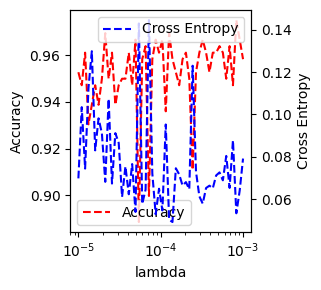

In [12]:
opt = 'AdamOptimiser'
base = f'Data/NrHidden1/{opt}/Lambda'
plot_lamda(f'{base}/Acc_Ent.npy', f'{opt}', f'{target}{opt}Lambda.png')

Based on this we choose $\lambda = 1*10^{-3}$

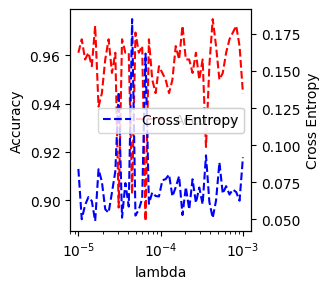

In [14]:
opt = 'RMSPropOptimiser'
base = f'Data/NrHidden1/{opt}/Lambda'
plot_lamda(f'{base}/Acc_Ent.npy', f'{opt}', f'{target}{opt}Lambda.png')

Based on this we choose $\lambda = 4*10^{-4}$

In [ ]:
import Hyper as hp
import optimisers as op
import lrSchedules as lrs
import numpy as np
import Data
import ActivationFunctions as AF
import plot

In [10]:
[lr_range, ep_range] = [np.logspace(0, 1.5, 10), np.logspace(2.5, 3.5, 10)]
Lmd = 1e-3
shape = (64, 25, 10)
#Optimiser
hp.NetworkToLrEpoch(0, 215, lrs.hyperbolic_lr, op.Optimiser, lr_range, ep_range,
                    Lmd,'Optimiser_sigmoid_2', AF.Sigmoid(), shape)

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,

In [11]:
[lr_range, ep_range] = [np.logspace(-1, 1, 10), np.logspace(2.2, 2.8, 10)]
Lmd = 1e-3
shape = (64, 25, 10)
#MomentumOptimiser
hp.NetworkToLrEpoch(1.5, 464, lrs.hyperbolic_lr, op.MomentumOptimiser, lr_range, ep_range,
                 Lmd, 'MomentumOptimiser_sigmoid_2', AF.Sigmoid(), shape)

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 2.1544346900318834 , Epochs: 541.1695265464638, Best Acc: 0.9749303621169917, Best CE: 0.0582178143728184


In [12]:
[lr_range, ep_range] = [np.logspace(-1.5, 0, 10), np.logspace(2.5, 3.5, 10)]
Lmd = 4e-4
shape = (64, 25, 10)
#AdaGradOptimiser
hp.NetworkToLrEpoch(0, 0, 0, op.AdaGradOptimiser, lr_range, ep_range,
                 Lmd, 'AdaGradOptimiser_sigmoid_2', AF.Sigmoid(), shape)

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.46415888336127775 , Epochs: 1136.4636663857243, Best Acc: 0.9749303621169917, Best CE: 0.047235764427311755


In [13]:
[lr_range, ep_range] = [np.logspace(-3, -1, 10), np.logspace(2.5, 3, 10)]
Lmd = 1e-3
shape = (64, 25, 10)
#AdamOptimiser
hp.NetworkToLrEpoch(0, 0, 0, op.AdamOptimiser, lr_range, ep_range,
                 Lmd, 'AdamOptimiser_sigmoid_2', AF.Sigmoid(), shape)

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.001 , Epochs: 1000.0, Best Acc: 0.9749303621169917, Best CE: 0.06234037522799712


In [14]:
[lr_range, ep_range] = [np.logspace(-3, -1, 10), np.logspace(2.5, 3, 10)]
Lmd = 4e-4
shape = (64, 25, 10)
#RMSPropOptimiser
hp.NetworkToLrEpoch(0, 0, 0, op.RMSPropOptimiser, lr_range, ep_range,
                    Lmd, 'RMSPropOptimiser_sigmoid_2', AF.Sigmoid(), shape)

.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,.,,,,,,,,,,

Lr: 0.007742636826811269 , Epochs: 599.4842503189409, Best Acc: 0.9749303621169917, Best CE: 0.05308580104488163


In [15]:
from plot import *
import os

target = f"Data/Plots/NrHidden1/"
os.makedirs(target, exist_ok=True)

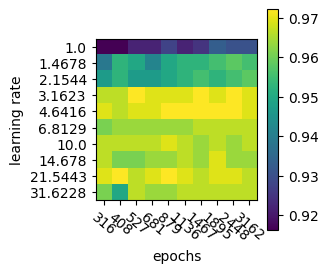

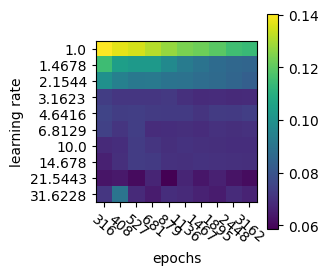

In [22]:
opt = 'Optimiser'
base = f'Data/NrHidden1/{opt}/LrEpoch'
for item in os.listdir(base):
    if item.endswith("_2.npy"):
        plot_lr_epochs(f'{base}/{item}', f"{opt}{item[:3]}.png", f"{opt}{item[:3]}", f"{target}{opt}{item[:3]}.png")

Where we choose $\text{Lr}= 4.6$ and $\text{Epochs} = 1900$.

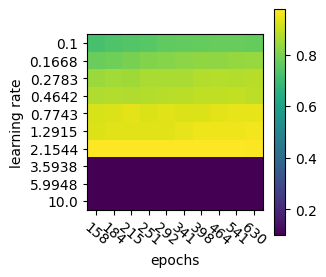

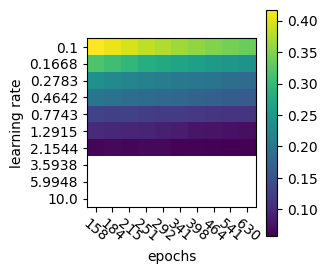

In [23]:
opt = 'MomentumOptimiser'
base = f'Data/NrHidden1/{opt}/LrEpoch'
for item in os.listdir(base):
    if item.endswith("_2.npy"):
        plot_lr_epochs(f'{base}/{item}', f"{opt}{item[:3]}.png", f"{opt}{item[:3]}", f"{target}{opt}{item[:3]}.png")

Where we choose $\text{Lr} = 2.15$ with $\text{Epochs}=500$

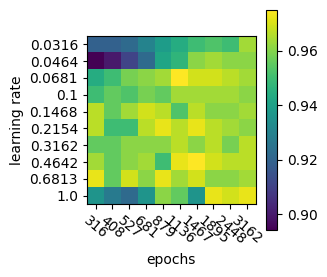

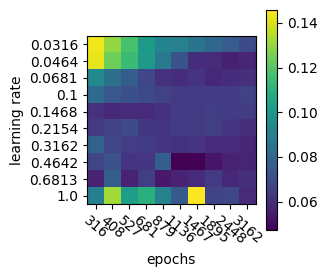

In [24]:
opt = 'AdaGradOptimiser'
base = f'Data/NrHidden1/{opt}/LrEpoch'
for item in os.listdir(base):
    if item.endswith("_2.npy"):
        plot_lr_epochs(f'{base}/{item}', f"{opt}{item[:3]}.png", f"{opt}{item[:3]}", f"{target}{opt}{item[:3]}.png")

Where we choose $\text{Lr} = 0.5$ and $\text{Epochs}=1500$.

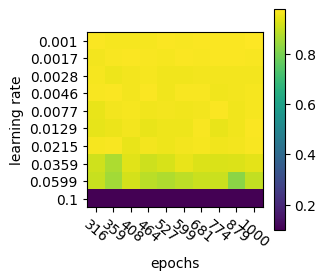

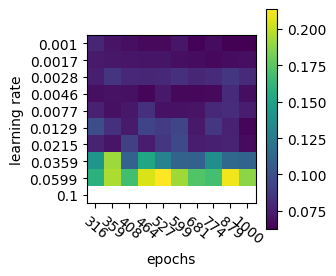

In [25]:
opt = 'AdamOptimiser'
base = f'Data/NrHidden1/{opt}/LrEpoch'
for item in os.listdir(base):
    if item.endswith("_2.npy"):
        plot_lr_epochs(f'{base}/{item}', f"{opt}{item[:3]}.png", f"{opt}{item[:3]}", f"{target}{opt}{item[:3]}.png")

Where we then choose $\text{Lr} = 0.002$ and $\text{Epochs}=400$.

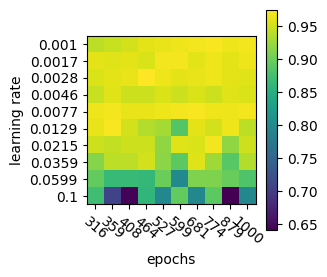

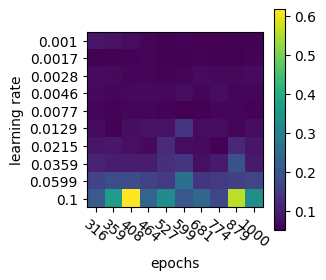

In [26]:
opt = 'RMSPropOptimiser'
base = f'Data/NrHidden1/{opt}/LrEpoch'
for item in os.listdir(base):
    if item.endswith("_2.npy"):
        plot_lr_epochs(f'{base}/{item}', f"{opt}{item[:3]}.png", f"{opt}{item[:3]}", f"{target}{opt}{item[:3]}.png")

Where we choose $\text{Lr} = 0.003$ and $\text{Epochs}=500$.

We then see how well these models predict the validation data.

Optimiser: Optimiser, Mean Accuracy: 0.8986072423398328, Std: 0.004168977589720286
Optimiser: Optimiser, Mean Cross Entropy: 0.1463081614544506, Std: 0.003991771616414623
Optimiser: Momentum, Mean Accuracy: 0.8986072423398328, Std: 0.004525926687819476
Optimiser: Momentum, Mean Cross Entropy: 0.15402148770437124, Std: 0.007210624708856532
Optimiser: AdaGrad, Mean Accuracy: 0.8986072423398328, Std: 0.011765299209996041
Optimiser: AdaGrad, Mean Cross Entropy: 0.15219589810509104, Std: 0.011917901041417687
Optimiser: Adam, Mean Accuracy: 0.8913649025069637, Std: 0.005842946229360183
Optimiser: Adam, Mean Cross Entropy: 0.1557011276470888, Std: 0.004372795260419604
Optimiser: RMSProp, Mean Accuracy: 0.901392757660167, Std: 0.012531723542286348
Optimiser: RMSProp, Mean Cross Entropy: 0.14469381363801298, Std: 0.009147219320484958


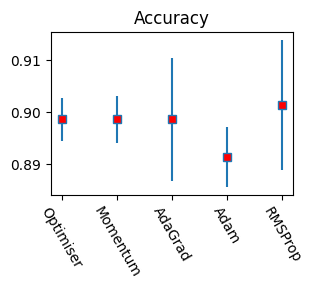

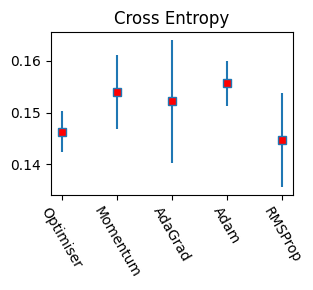

In [3]:
import validate as vld

opt1 = op.LrScheduleOptimiser(lrs.hyperbolic_lr(4.6, 215), op.Optimiser(4.6))
opt2 = op.LrScheduleOptimiser(lrs.hyperbolic_lr(2.15, 464), op.MomentumOptimiser(2.15, momentum=1.5))
optimisers = [opt1, opt2, op.AdaGradOptimiser(0.5), op.AdamOptimiser(2e-3), op.RMSPropOptimiser(3e-3)]
opt_names = ['Optimiser', 'Momentum', 'AdaGrad', 'Adam', 'RMSProp']
n_epochs = [1900, 500, 1500, 400, 500]
Lmds = [1e-3, 1e-3, 4e-4, 1e-3, 4e-4]
vld.validate(n_epochs, optimisers, opt_names, Lmds, [AF.Sigmoid()], (64, 24, 10), '2nd_validation')

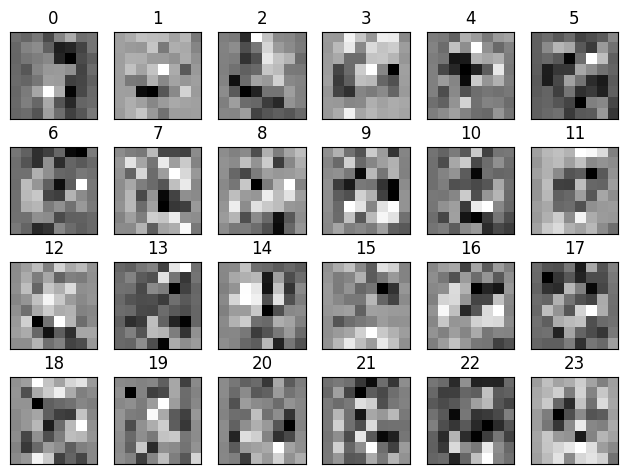

In [6]:
import plotweights as pw

optimiser = op.Optimiser(2.15)
sch_opt = op.LrScheduleOptimiser(lrs.hyperbolic_lr(2.15, 464), optimiser)
pw.weights_heat(1900, sch_opt, 1e-3, [AF.Sigmoid(), AF.SoftMax()], (64, 24, 10), '2ndOptimiserVisual', (4, 6))